In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Intro

* This notebook follows the tutorial but instead of using linear regression, RegressorChain was used to train the model.
* I did initial EDA and preprocessing of the other data sets and decided to exclude 'transactions', 'holiday_events', 'oil' and 'stores' in ML modeling. I found that 'onpromotion' feature was highly correlated to sales.
 

In [2]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex6 import *

# Setup notebook
from pathlib import Path
import ipywidgets as widgets
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import (create_multistep_example,
                                          load_multistep_data,
                                          make_lags,
                                          make_multistep_target,
                                          plot_multistep)
from learntools.time_series.utils import plot_periodogram, seasonal_plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import (create_multistep_example,
                                          load_multistep_data,
                                          make_lags,
                                          make_multistep_target,
                                          plot_multistep)

from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor


comp_dir = Path('../input/store-sales-time-series-forecasting')


store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales','onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)


In [3]:
store_sales.head()

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

In [4]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

In [5]:
from sklearn.multioutput import RegressorChain
from xgboost import XGBRegressor
from sklearn.multioutput import RegressorChain

model = RegressorChain(base_estimator=XGBRegressor())
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [6]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)

In [7]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

# Forecasting with ML -apply the DirRec strategy to XGBoost

In [8]:
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import (create_multistep_example,
                                          load_multistep_data,
                                          make_lags,
                                          make_multistep_target,
                                          plot_multistep)

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

In [9]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

Three forecasting tasks:

a. 3-step forecast using 4 lag features with a 2-step lead time

b. 1-step forecast using 3 lag features with a 1-step lead time

c. 3-step forecast using 4 lag features with a 1-step lead time

In [10]:
datasets = load_multistep_data()

data_tabs = widgets.Tab([widgets.Output() for _ in enumerate(datasets)])
for i, df in enumerate(datasets):
    data_tabs.set_title(i, f'Dataset {i+1}')
    with data_tabs.children[i]:
        display(df)

display(data_tabs)

In [11]:
y = family_sales.loc[:, 'sales']

X = make_lags(y, lags=4).dropna() #4 lag features

y = make_multistep_target(y, steps=16).dropna() #multistep

y, X = y.align(X, join='inner', axis=0)

In [12]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y)

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.333333     6.018518    10.259259   
           BABY CARE                      0.351852     0.277778     0.259259   
           BEAUTY                         5.925926     6.518518    10.037037   
           BEVERAGES                   3258.796387  3507.277832  4848.518555   
           BOOKS                          0.407407     0.537037     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955658   403.601349   377.313965   
           PREPARED FOODS                84.698647    87.836800    88.735962   
           PRODUCE                     2257.140625  2609.180176  3122.895752   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333332    57.481480   
           SEAFOOD                       20.488333    20.346851    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     9.388889     5.944445     4.777778   
           BABY CARE                      0.240741     0.444444     0.240741   
           BEAUTY                        11.611111     5.648148     6.500000   
           BEVERAGES                   5503.647949  3448.203613  3171.740723   
           BOOKS                          0.722222     0.500000     0.518519   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436096   533.497070   416.454010   
           PREPARED FOODS                77.172997    91.886757   100.384964   
           PRODUCE                     1792.220947  2079.319580  2418.970215   
           SCHOOL AND OFFICE SUPPLIES    51.907406    63.222221    85.203705   
           SEAFOOD                       17.116297    25.553963    24.209518   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.314815     5.388889     5.240741   
           BABY CARE                      0.277778     0.296296     0.296296   
           BEAUTY                         5.277778     4.370370     4.703704   
           BEVERAGES                   3046.870361  2693.722168  3226.037109   
           BOOKS                          0.481481     0.388889     0.444444   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051727   313.780884   
           PREPARED FOODS               102.248146    86.627441    77.344131   
           PRODUCE                     2675.105713  2111.133545  2168.535400   
           SCHOOL AND OFFICE SUPPLIES   100.277779    64.407410    59.759258   
           SEAFOOD                       23.512852    18.419851    18.481131   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     8.500000    10.259259     6.407407   
           BABY CARE                      0.388889     0.425926     0.314815   
           BEAUTY                         7.777778     9.037037     5.648148   
           BEVERAGES                   4667.296387  5580.611328  3700.370361   
           BOOKS                          0.574074     0.555556     0.388889   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270203   278.819855   468.857361   
           PREPARED FOODS                84.796539    78.791443    96.286926   
           PRODUCE                     2663.076172  1670.264893  2198.854492   
           SCHOOL AND OFFICE SUPPLIES  

In [13]:
model = RegressorChain(base_estimator=XGBRegressor())


In [14]:
model.fit(X, y)
y_pred1 = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
).clip(0.0)

**Sample of the 16-step predictions this model makes on the 'grocery' training data**

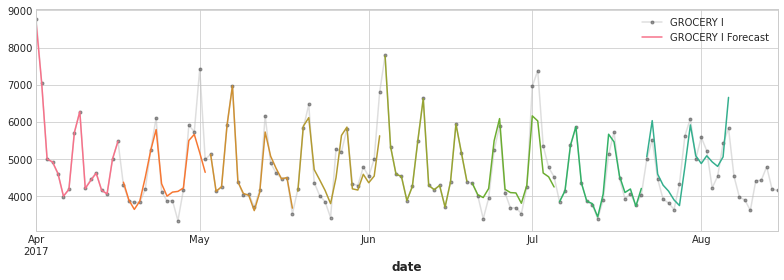

In [15]:
FAMILY = 'GROCERY I'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred1.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

In [16]:
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(y, y_pred1)
print('MAE:', score)

MAE: 33.960145347017296
